# **Initial imports and checks**

In [1]:
# Standard library
import os
import time
import io
import glob
import random
import warnings
from base64 import b64decode

# Numerical & data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Audio processing
import librosa
import librosa.display
import ffmpeg
from scipy.io.wavfile import read as wav_read

# Regex
import regex as re

# Progress & display
from tqdm import tqdm
from IPython.display import Audio, HTML, display, Javascript

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow / Keras
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import (
    Dense, Dropout, BatchNormalization, Input, Add, Flatten,
    Activation, AveragePooling1D, Conv1D, GlobalAveragePooling1D
)
from keras.optimizers import Adam
from keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, LearningRateScheduler
)
from keras.utils import to_categorical

warnings.filterwarnings("ignore")

# **Building and Training Model**

*Preparing data for training*

In [7]:
import pickle
import os

def prepare_data(train_csv, val_csv, test_csv):
    # Load features and prepare for training.

    train_df = pd.read_csv(train_csv)
    val_df = pd.read_csv(val_csv)
    test_df = pd.read_csv(test_csv)

    # Separate features and labels
    X_train = train_df.drop('Label', axis=1).values
    X_val = val_df.drop('Label', axis=1).values
    X_test = test_df.drop('Label', axis=1).values

    y_train = train_df['Label'].values
    y_val = val_df['Label'].values
    y_test = test_df['Label'].values

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train)
    y_val_enc = label_encoder.transform(y_val)
    y_test_enc = label_encoder.transform(y_test)

    # One-hot encode
    y_train_cat = to_categorical(y_train_enc)
    y_val_cat = to_categorical(y_val_enc)
    y_test_cat = to_categorical(y_test_enc)

    # Scale features (FIT on train only!)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Create artifacts directory if it doesn't exist
    artifacts_dir = os.path.join('..', 'app', 'artifacts')
    os.makedirs(artifacts_dir, exist_ok=True)

    # Save label encoder and scaler
    label_encoder_path = os.path.join(artifacts_dir, 'label_encoder.pkl')
    scaler_path = os.path.join(artifacts_dir, 'scaler.pkl')

    with open(label_encoder_path, 'wb') as f:
        pickle.dump(label_encoder, f)
    
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    print(f"\n✓ Saved label_encoder.pkl to {label_encoder_path}")
    print(f"✓ Saved scaler.pkl to {scaler_path}")

    print(f"\nTraining: {X_train.shape}")
    print(f"Validation: {X_val.shape}")
    print(f"Test: {X_test.shape}")
    print(f"\nFeatures: {X_train.shape[1]}")
    print(f"Classes: {y_train_cat.shape[1]}")
    print(f"Class names: {label_encoder.classes_}")
    print("="*50 + "\n")

    return X_train, X_val, X_test, y_train_cat, y_val_cat, y_test_cat, label_encoder, scaler


# Usage
X_train, X_val, X_test, y_train, y_val, y_test, encoder, scaler = prepare_data(
    "Split/Features/train_features.csv",
    "Split/Features/val_features.csv",
    "Split/Features/test_features.csv"
)


✓ Saved label_encoder.pkl to ..\app\artifacts\label_encoder.pkl
✓ Saved scaler.pkl to ..\app\artifacts\scaler.pkl

Training: (14000, 184)
Validation: (1131, 184)
Test: (1132, 184)

Features: 184
Classes: 6
Class names: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']



*Build & Train model*

In [8]:
def build_model(input_dim, num_classes):
    from keras.optimizers import Adam
    from keras.regularizers import l2

    model = Sequential([
        # Block 1: Wide feature extraction
        Dense(2048, activation='relu', kernel_regularizer=l2(0.0005), input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.35),

        Dense(1536, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.35),

        # Block 2: Deep pattern learning
        Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(768, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),

        # Block 3: Mid-level representation
        Dense(512, activation='relu', kernel_regularizer=l2(0.0003)),
        BatchNormalization(),
        Dropout(0.25),

        Dense(384, activation='relu', kernel_regularizer=l2(0.0003)),
        BatchNormalization(),
        Dropout(0.25),

        # Block 4: Fine discrimination
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.15),

        Dense(64, activation='relu'),
        Dropout(0.1),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Use Adam with specific parameters
    optimizer = Adam(
        learning_rate=0.0005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

def train_model(X_train, y_train, X_val, y_val, save_path):
    print("\n" + "="*50)
    print("STEP 6: TRAINING OPTIMIZED MODEL")
    print("="*50 + "\n")

    model = build_model(X_train.shape[1], y_train.shape[1])
    model.summary()

    # Compute class weights
    from sklearn.utils.class_weight import compute_class_weight

    y_train_classes = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_classes),
        y=y_train_classes
    )
    class_weight_dict = dict(enumerate(class_weights))

    print("\nClass weights (balanced):")
    for i, weight in class_weight_dict.items():
        print(f"  Class {i}: {weight:.3f}")

    # Advanced callbacks
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

    callbacks = [
        # Stop if no improvement in val_accuracy
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),

        # Reduce learning rate when stuck
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=10,
            min_lr=1e-8,
            verbose=1,
            cooldown=3
        ),

        # Save best model
        ModelCheckpoint(
            save_path,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    print("\nStarting training...")
    print("="*50)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=250,  # More epochs for convergence
        batch_size=64,  # Optimal batch size
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )

    print(f"\n{'='*50}")
    print(f"Best model saved to: {save_path}")
    print(f"{'='*50}\n")

    return model, history

In [ ]:
model, history = train_model(
    X_train, y_train, X_val, y_val,
    "Split/emotion_model_final.keras"
)


STEP 6: TRAINING OPTIMIZED MODEL



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 2048)           │       378,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1536)           │     3,147,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 768)            │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,644,678 (25.35 MB)

 Trainable params: 6,631,366 (25.30 MB)

 Non-trainable params: 13,312 (52.00 KB)


Class weights (balanced):
  Class 0: 0.984
  Class 1: 0.982
  Class 2: 0.978
  Class 3: 0.981
  Class 4: 1.112
  Class 5: 0.977

Starting training...
Epoch 1/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.2390 - loss: 4.2505
Epoch 1: val_accuracy improved from -inf to 0.19717, saving model to /content/drive/MyDrive/AudioFiles/emotion_model_final.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 204ms/step - accuracy: 0.2393 - loss: 4.2493 - val_accuracy: 0.1972 - val_loss: 4.0897 - learning_rate: 5.0000e-04
Epoch 2/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4148 - loss: 3.5907
Epoch 2: val_accuracy improved from 0.19717 to 0.32980, saving model to /content/drive/MyDrive/AudioFiles/emotion_model_final.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 48s 219ms/step - accuracy: 0.4148 - loss: 3.5905 - val_accuracy: 0.3298 - val_loss: 3.7290 - learning_rate: 5.0000e-04
Epoch 3/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4702 - loss: 3.3706
Epoch 3: val_accuracy imp

# **Evaluating Model performance**

*Plotting - Accuracy vs Epoch*

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

*Evaluating Model*

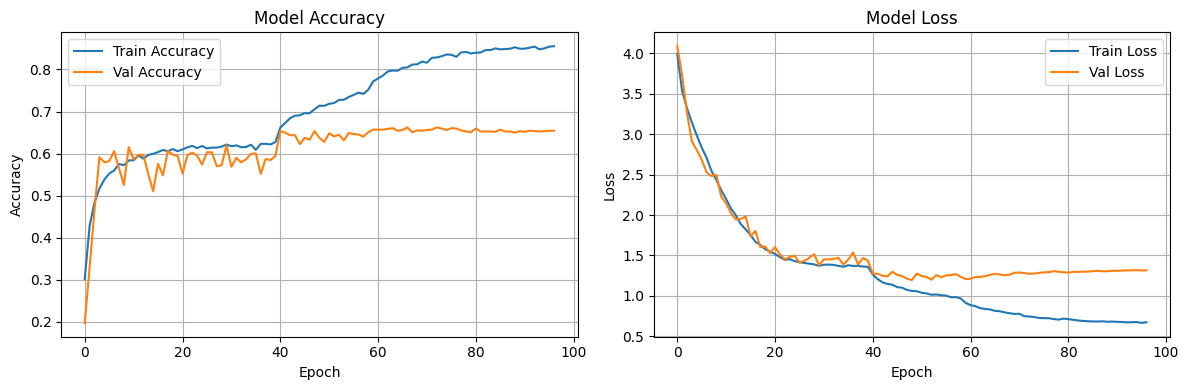

In [ ]:
plot_training_history(history)

In [ ]:
def evaluate_model(model, X_test, y_test, label_encoder):
    print("\n" + "="*50)
    print("STEP 7: FINAL EVALUATION")
    print("="*50)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"\n{'='*50}")
    print(f"FINAL TEST ACCURACY: {test_acc*100:.2f}%")
    print(f"FINAL TEST LOSS: {test_loss:.4f}")
    print(f"{'='*50}\n")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Classification report
    from sklearn.metrics import classification_report, confusion_matrix

    print("\nClassification Report:")
    print("="*50)
    print(classification_report(y_test_classes, y_pred_classes,
                                target_names=label_encoder.classes_))

    print("\nConfusion Matrix:")
    print("="*50)
    print(confusion_matrix(y_test_classes, y_pred_classes))
    print("="*50 + "\n")

In [ ]:
evaluate_model(model, X_test, y_test, encoder)


STEP 7: FINAL EVALUATION

FINAL TEST ACCURACY: 65.90%
FINAL TEST LOSS: 1.3004

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.77      0.77       192
     disgust       0.59      0.58      0.59       192
        fear       0.69      0.55      0.62       193
       happy       0.68      0.65      0.67       193
     neutral       0.57      0.75      0.64       170
         sad       0.68      0.66      0.67       192

    accuracy                           0.66      1132
   macro avg       0.66      0.66      0.66      1132
weighted avg       0.66      0.66      0.66      1132


Confusion Matrix:
[[148  16   5  16   3   4]
 [ 15 112   5   9  36  15]
 [  9  19 107  17  14  27]
 [ 17  13  13 126  17   7]
 [  2  14   9  11 127   7]
 [  3  16  15   5  27 126]]

